# AI 서울 전세가격 예측 서비스


- TOC
1. EDA
2. Model
3. Data Source + (Seoul_Data.csv)

<hr>

## 1. EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
plt.rc('font', family='gulim')


def hist(ncols, nrows, df):
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15, 30))
    for i, coln in enumerate(df.columns):
        df_hists = df[coln].value_counts()
        row = i // ncols
        col = i % ncols
        sns.histplot(x=df_hists.index, y=df_hists.values,  bins=100, kde=True, ax=axs[row][col])
        axs[row][col].set_xlabel(coln)
    plt.show()

def hist_col(ncols, nrows, df, coli,hue_col):
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15, 16))
    axs = axs.ravel()
    for i, col in enumerate(coli):
        sns.kdeplot(data=df, x=col, hue=hue_col, bw_adjust=3, ax=axs[i], fill=True)

def resameple(df, col, nj):
    list1 = df[col].value_counts()[df[col].value_counts() >= nj].index.tolist()
    mask1 = df[col].isin(list1)
    df = pd.concat([df.loc[mask1].groupby(col).apply(lambda x: x.sample(n=min(nj, x.shape[0]))),
                    df.loc[~mask1]])
    print(col, nj, df.shape)
    return df.reset_index(drop=True)

def edgecut( df, cols, percent):
    for col in cols:
        q = np.percentile(df[col], q = percent)
        df = df[df[col] <= q]
        print(col, " : ", int(q), "\n -> ", df.shape)
    return df

### Feature

- 부동산 데이터 : 동 ~ 구분
- 금융 데이터 : 종가 ~ 한국은행기준금리
- 인프라 데이터 : 대학최소거리 ~ 스타벅스
- Y : 전세 (월세는 보증금과 전세로 환산)

In [2]:
df = pd.read_csv('Seoul_Data.csv')
print(df.columns.to_list)
print(df.shape)
print(df.dtypes)

<bound method IndexOpsMixin.tolist of Index(['동', '전용면적(㎡)', '계약년월', '층', '도로명', '구분', '건물나이', '종가', '거래량', '변동 %',
       '한국은행기준금리', '대학최소거리', '역최소거리', '마트', '스타벅스', 'Y'],
      dtype='object')>
(3189178, 16)
동            object
전용면적(㎡)     float64
계약년월        float64
층           float64
도로명           int64
구분           object
건물나이        float64
종가          float64
거래량         float64
변동 %        float64
한국은행기준금리    float64
대학최소거리      float64
역최소거리       float64
마트          float64
스타벅스        float64
Y           float64
dtype: object


In [3]:
# 도로명 주소는 인코딩하여 마스킹함.
df.head(5)

,동,전용면적(㎡),계약년월,층,도로명,구분,건물나이,종가,거래량,변동 %,한국은행기준금리,대학최소거리,역최소거리,마트,스타벅스,Y
0,개포동,77.8,201401.0,2.0,70693,아파트,26.0,1941.15,5.09,-3.49,2.5,3.394074,0.833371,3.0,2.0,33000.0
1,개포동,77.8,201405.0,9.0,70693,아파트,26.0,1994.96,4.29,1.69,2.5,3.394074,0.833371,3.0,2.0,39000.0
2,개포동,77.8,201405.0,1.0,70693,아파트,26.0,1994.96,4.29,1.69,2.5,3.394074,0.833371,3.0,2.0,33000.0
3,개포동,77.8,201406.0,9.0,70693,아파트,26.0,2002.21,4.60,0.36,2.5,3.394074,0.833371,3.0,2.0,35000.0
4,개포동,77.8,201407.0,3.0,70693,아파트,26.0,2076.12,6.98,3.69,2.5,3.394074,0.833371,3.0,2.0,37000.0


### Resampling & Outlier remove

아파트 데이터가 210 만건으로 절반 이상. 그도 최근 지어진 대규모 아파트 단지의 영향으로 계약건수가 급증한 것으로 추정된다. 
적당량을 설정해서 표본 추출을 해주자.

- 도로명이 같으면 같은 아파트 단지, 최대 200건으로 제한해주자.
- 계약건수가 약 8년간 매월 만건에서 3만건으로 뛰었다. 2만건으로 제한해주자.
- 특수한 경우를 제거하기 위해 상위 5%를 제거해준다. 

    집의 면적, 집값, 층, 등 데이터 분포가 보통 좌편향(positive skewness)되어있어 하위 이상치는 직접 제거해주었다. <br>
    ex) 지하 8~2층 직접 제거...


In [4]:
df = resameple(df, '도로명', 200)       
df = resameple(df, '계약년월', 20000)
df = edgecut(df, ['전용면적(㎡)', '건물나이', '대학최소거리', '역최소거리','Y'], 97)

도로명 200 (1915617, 16)
계약년월 20000 (1908673, 16)
전용면적(㎡)  :  121 
 ->  (1851523, 16)
건물나이  :  33 
 ->  (1798138, 16)
대학최소거리  :  4 
 ->  (1744214, 16)
역최소거리  :  2 
 ->  (1691893, 16)
Y  :  58060 
 ->  (1641139, 16)


In [5]:
df['구분'].value_counts()

구분
연립다세대    924507
아파트      527328
오피스텔     189304
Name: count, dtype: int64

### Histogram

- 재개발된 동에 계약 건수가 많아 보인다. 특정 전용면적으로 지어진 집이 많다.
- 층, 건물나이, 마트, 스타벅스는 분포가 좌편향(Positive skew)되어 있다.


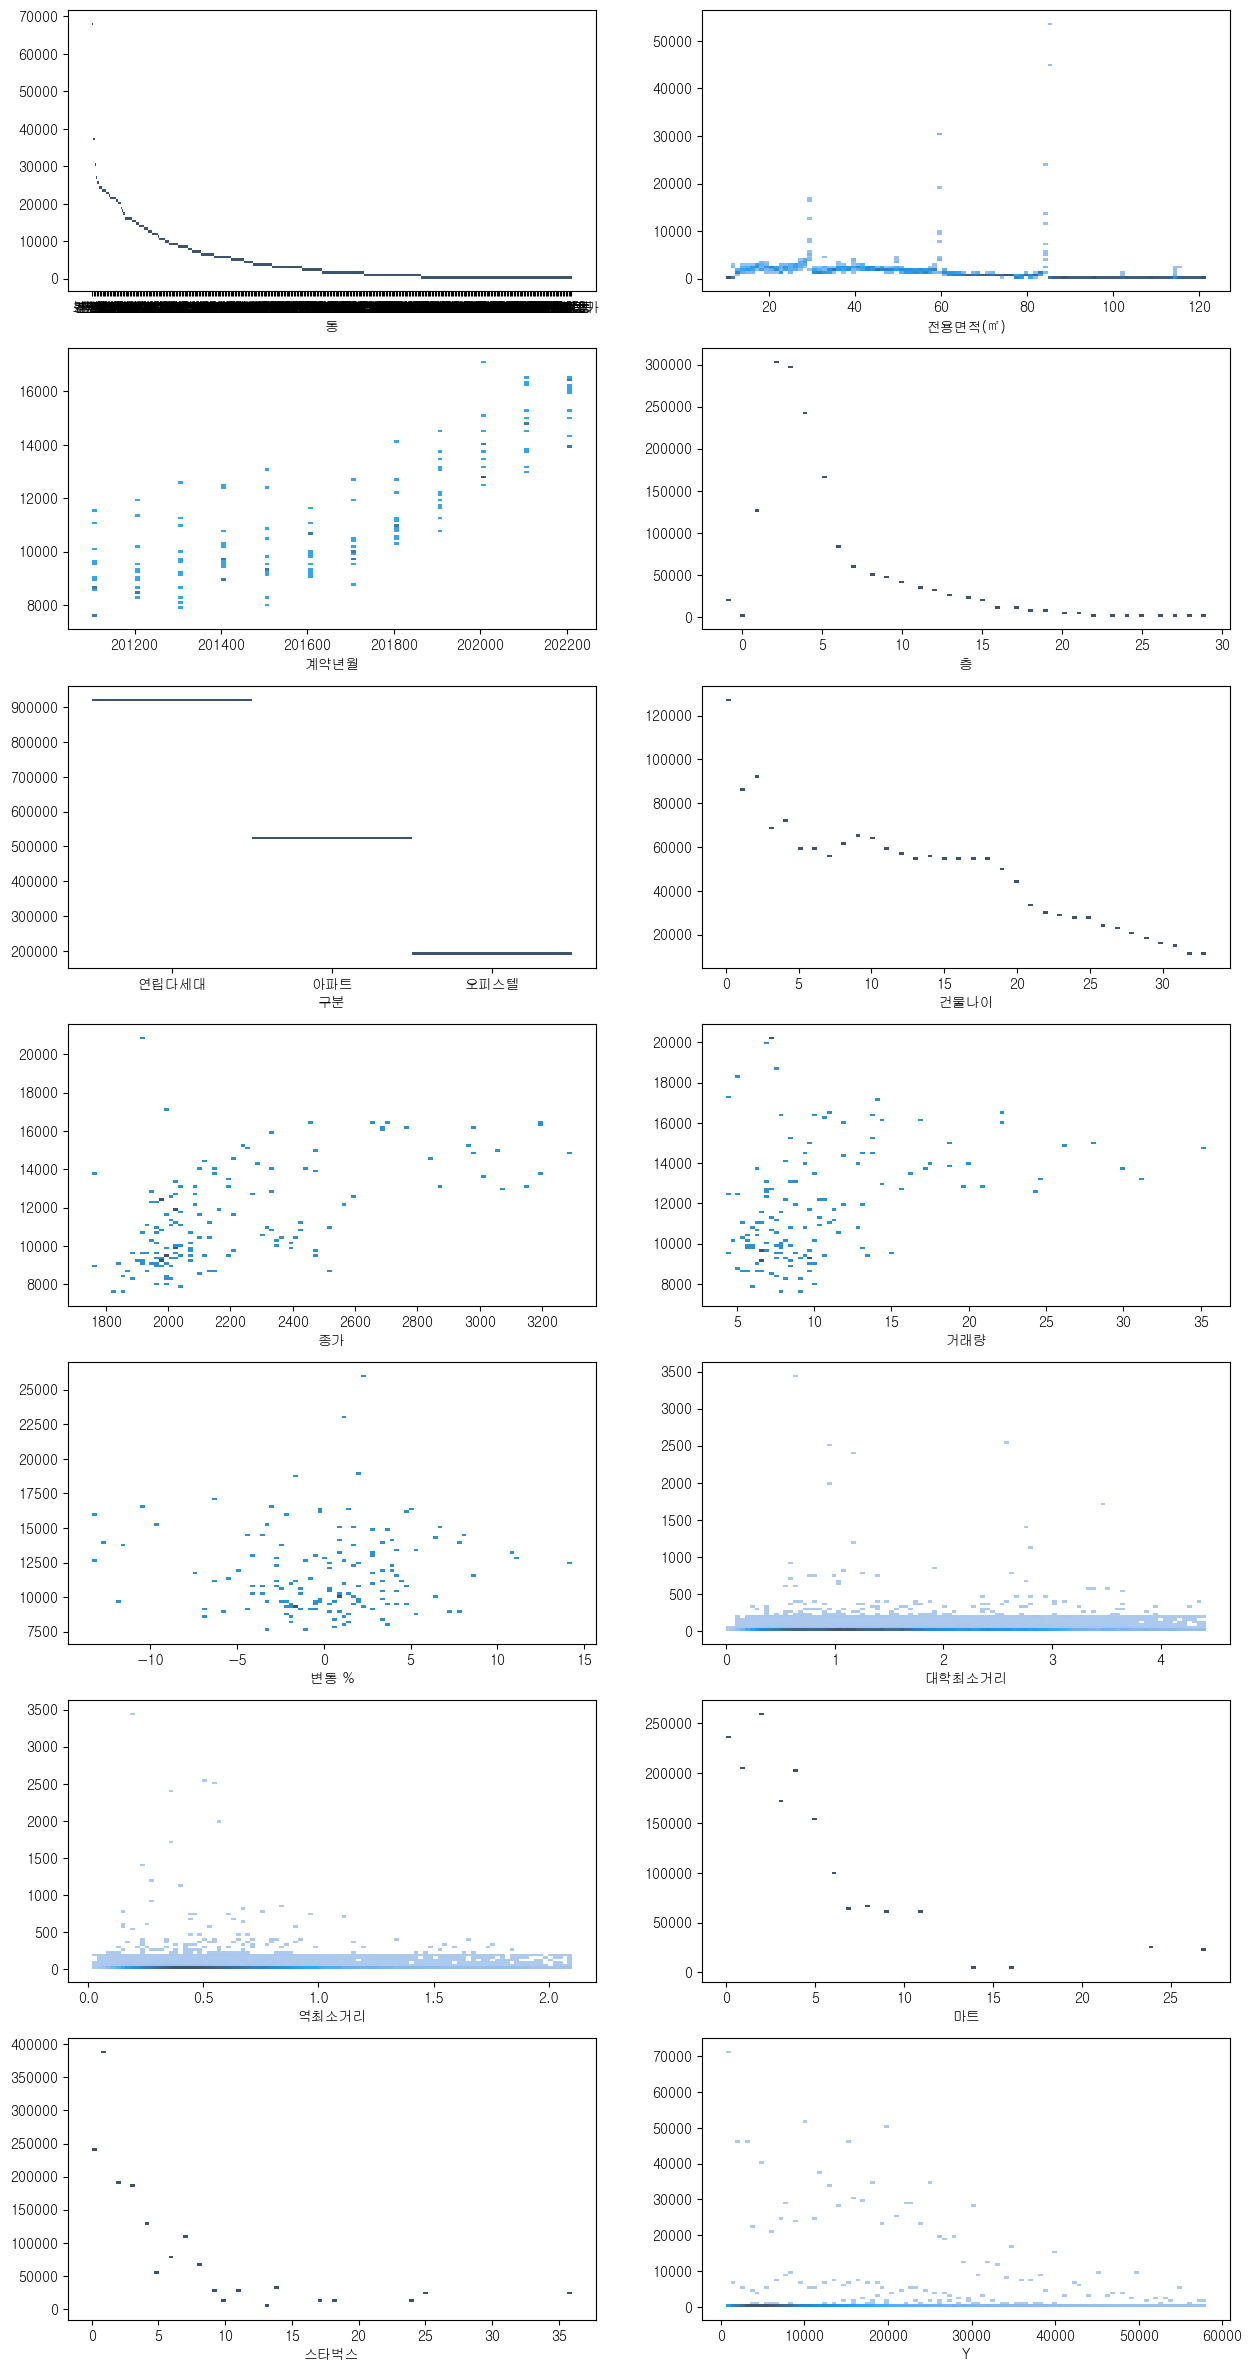

In [6]:
hist(2, 7, df.drop(['도로명','한국은행기준금리'], axis=1))

아파트, 오피스텔, 다세대 주택별 데이터 표본차이가 크다. 샘플해서 구분별로 히스토그램을 봐보자.

구분 50000 (150000, 16)


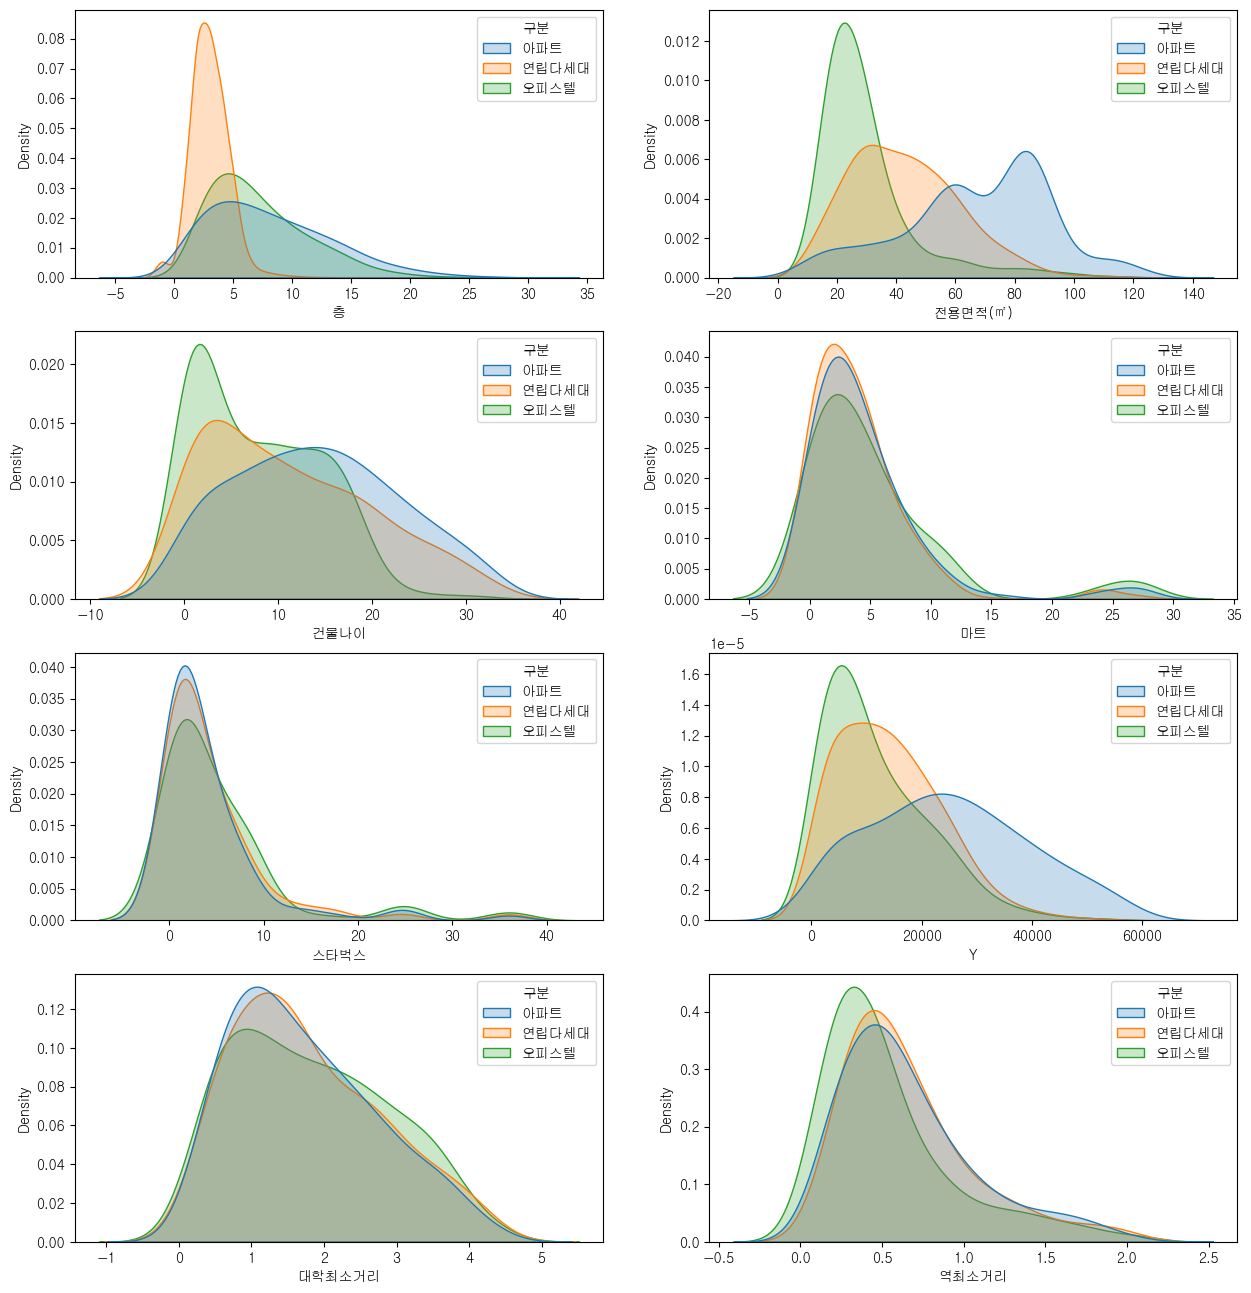

In [7]:
hist_col(2, 4, resameple(df, '구분', 50000), ['층', '전용면적(㎡)', '건물나이', '마트', '스타벅스', 'Y','대학최소거리','역최소거리'], '구분')

In [8]:
scaler = MinMaxScaler()
values = df['계약년월'].values.reshape(-1, 1)
scaled_values = scaler.fit_transform(values)
df['계약년월'] = scaled_values

In [9]:
df = df.drop('도로명', axis=1)
df = df.drop_duplicates().reset_index(drop=True)
encoder = LabelEncoder()
for name, dtype in df.dtypes.items():
    if dtype == 'object':
        print(name)
        df[name] = encoder.fit_transform(df[name])

동
구분


### Correlationship Heatmap

결정적인 요소는 예상대로 면적이고, 그 외에 유의미한 상관관계가 잘 보여지진 않는다.

<Axes: >

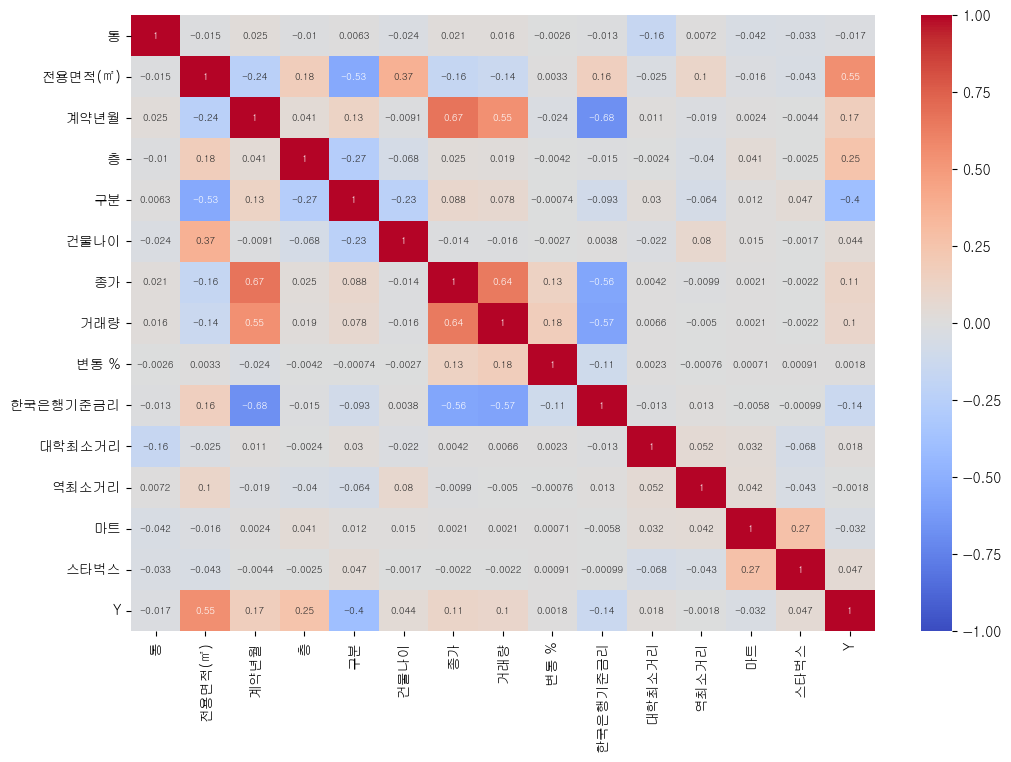

In [10]:
plt.figure(figsize=(12, 8))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True, vmin=-1, vmax=1, annot_kws={'size':7})

In [11]:
df.head(1)

,동,전용면적(㎡),계약년월,층,구분,건물나이,종가,거래량,변동 %,한국은행기준금리,대학최소거리,역최소거리,마트,스타벅스,Y
0,257,16.3,0.810981,4.0,1,9.0,1987.01,13.96,-6.23,1.25,1.53774,0.248763,11.0,1.0,7000.0


In [12]:
df = resameple(df, '구분', 200000)

구분 200000 (589302, 15)


## 2. Modeling

### MLP

Sequentail Data로 볼 수도 있지만, 동일 계약년월에 다양한 feature가 존재하여 Simple한 MLP Model을 빌드하였다.


- Output Summary

Infra Data를 통해 잘 예측할 것으로 기대했지만, mae 가 6000만원대로 저조한 예측율을 보인다.

왠만한 인프라는 서울에 다 존재하여 더욱 민감한 가공이 필요해보인다.
(ex : 역세권의 경우 m단위 log scaling)

In [13]:
import tensorflow as tf
import keras
import os
import pandas as pd
import numpy as np
from tensorflow.python.client import device_lib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [14]:
col_len = len(df.columns)
X = df.iloc[:, :col_len - 1]
Y = df.iloc[:, col_len - 1]

# train, validation, test Data split
train_ratio = 0.6 
val_ratio = 0.3  
test_ratio = 0.1  
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=test_ratio, shuffle=True)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=val_ratio/(train_ratio + val_ratio), shuffle=True)

# 정규화
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train) # train 기준으로 val, test를 정규화한다.
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# For GPU
# print(device_lib.list_local_devices())
print("현재 사용 중인 디바이스: ", tf.test.gpu_device_name())

현재 사용 중인 디바이스:  /device:GPU:0


In [18]:
batch_size = 32
epochs = 50
dropout_rate = 0.1
learning_rate = 0.0001

train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).shuffle(len(Y_train)).batch(batch_size).prefetch(2)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(784, activation=keras.layers.LeakyReLU(alpha=0.03), input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(784, activation=keras.layers.LeakyReLU(alpha=0.03)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(256, activation=keras.layers.LeakyReLU(alpha=0.03)),
    tf.keras.layers.Dense(64, activation=keras.layers.LeakyReLU(alpha=0.03)),
    tf.keras.layers.Dense(1)
])

opt = tf.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=opt, loss='mae', metrics=['mae'])

history = model.fit(train_ds, epochs = epochs, 
                    validation_data=(X_val, Y_val), verbose = 1)

현재 사용 중인 디바이스:  /device:GPU:0
Epoch 1/50
10909/10909 [==============================] - 59s 5ms/step - loss: 6952.5522 - mae: 6952.5522 - val_loss: 6319.9751 - val_mae: 6319.9751
Epoch 2/50
10909/10909 [==============================] - 59s 5ms/step - loss: 6212.6973 - mae: 6212.6973 - val_loss: 6125.0137 - val_mae: 6125.0137
Epoch 3/50
10909/10909 [==============================] - 59s 5ms/step - loss: 6114.9736 - mae: 6114.9736 - val_loss: 6067.7856 - val_mae: 6067.7856
Epoch 4/50
10909/10909 [==============================] - 59s 5ms/step - loss: 6068.1309 - mae: 6068.1309 - val_loss: 6027.5400 - val_mae: 6027.5400
Epoch 5/50
10909/10909 [==============================] - 58s 5ms/step - loss: 6034.2407 - mae: 6034.2407 - val_loss: 5989.3569 - val_mae: 5989.3569
Epoch 6/50
10909/10909 [==============================] - 59s 5ms/step - loss: 6003.4653 - mae: 6003.4653 - val_loss: 5959.3809 - val_mae: 5959.3809
Epoch 7/50
10909/10909 [==============================] - 59s 5ms/step - los

In [40]:
# train_loss = history.history['loss']
# val_loss = history.history['val_loss']
# train_acc = history.history['mae']
# val_acc = history.history['val_mae']
# epochs = range(1, len(train_loss) + 1)

# plt.plot(epochs, train_loss, 'bo', label='Training loss')
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.figure()

# plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
# plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.show()

In [31]:
Y_hat = model.predict(scaler.transform(X)).ravel().astype(int)

18417/18417 [==============================] - 26s 1ms/step


<Figure size 2000x1000 with 0 Axes>

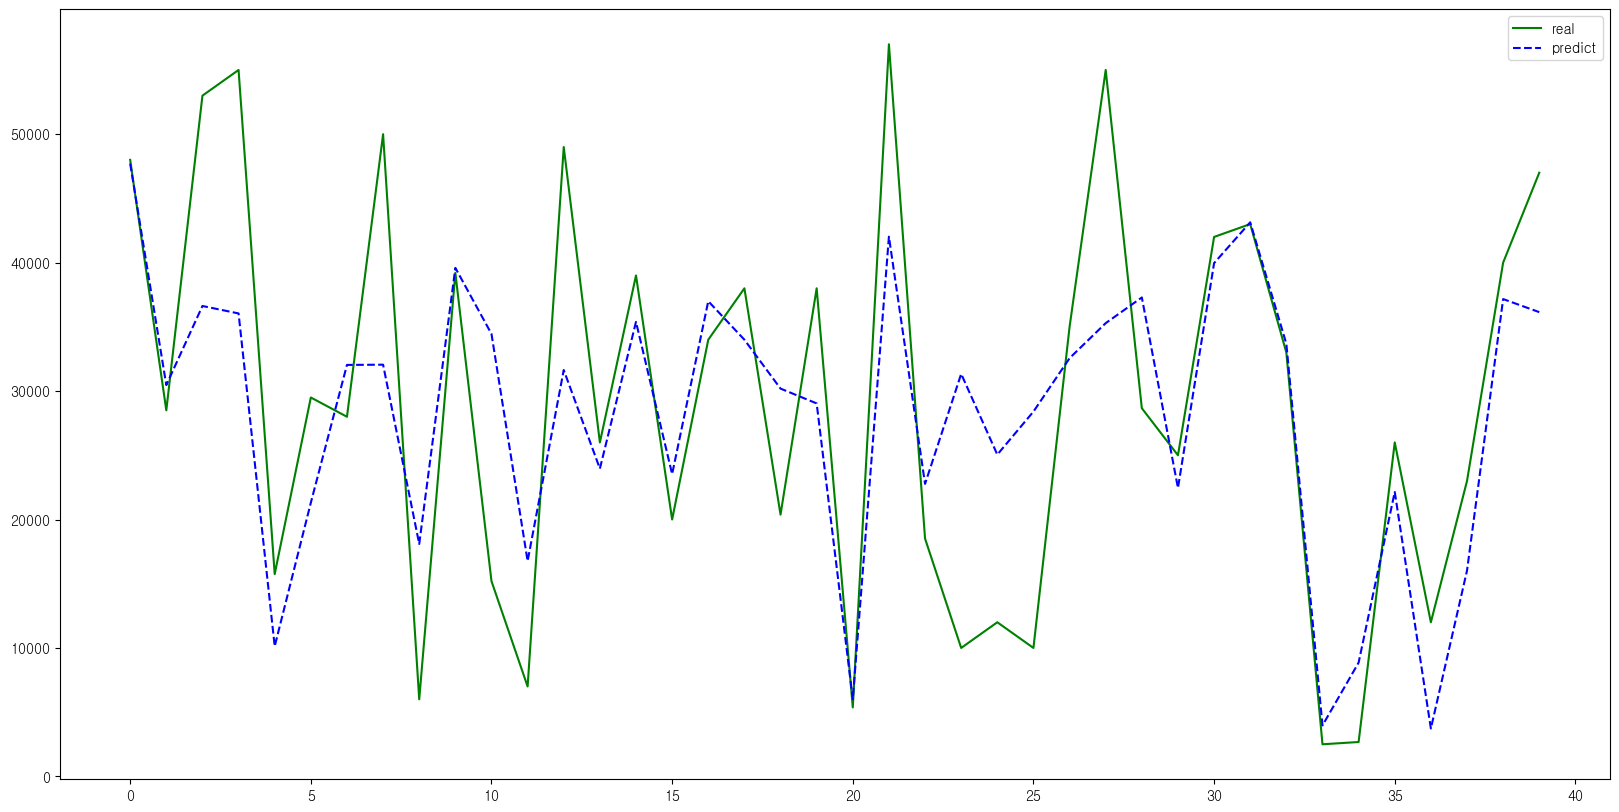

<Figure size 2000x1000 with 0 Axes>

In [39]:
s, l = 10000 , 40
sub_Y = Y[s: s+l]
sub_Y_hat = Y_hat[s:s+l]
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(np.arange(l), sub_Y, '-',color = 'green', label='real')
plt.plot(np.arange(l), sub_Y_hat, '--', color = 'blue', label='predict')
plt.legend()
plt.figure()

## 3. Data Source 

### 3.1 부동산 거래 데이터 수집

201405 ~ 202109 기간의 서울 전/월세 계약 건수를 취합, 월세는 년/월별 전월세환원율을 통해 전세로 치환하였다.

- 국토교통부 실거래가 공개시스템 (http://rtdown.molit.go.kr/) 
    - 아파트 (전월세) : 210만건 
    - 단독 / 다가구 (전월세) 110만건
    - 오피스텔 (전월세) 42만건

- 국가 통계 포털 전월세 환원율 (https://kosis.kr/statHtml/statHtml.do?orgId=408&tblId=DT_30404_N0010)

### 3.2 Financial Feature

기준 금리와, 코스피를 추가하였다.

- 한국은행 경제 통계 시스템(https://ecos.bok.or.kr/#/SearchStat)

### 3.3 Infra Feature

주소 가까운 대학교, 역 사이거리, 종속된 동에 포함된 스타벅스, 대형마트 갯수를 추가하였다.

- 서울교통공사 1, 8호선 역사 좌표 (https://www.data.go.kr/data/15099316/fileData.do?recommendDataYn=Y)
- 서울시 대규모점포 인허가 정보 (http://data.seoul.go.kr/dataList/OA-16096/A/1/datasetView.do;jsessionid=42EF715F85DF1A875B6C3C0992A448FA.new_portal-svr-11)
- 서울시 휴게음식점 인허가 정보 (http://data.seoul.go.kr/dataList/OA-16095/S/1/datasetView.do)
- 서울시 대학 및 전문대학 DB 정보 (한국어) (https://data.seoul.go.kr/dataList/OA-12974/S/1/datasetView.do)


### 3.4 Data

- [Data_Seoul.csv](https://github.com/Midnight-ML/Depoly/blob/main/preprocessing/Seoul_Data.zip)